### Table of Contents

* [Imported libraries](#imports)
* [Functions used](#functions)
* [Data Structuring](#data_structuring)
* [Data displaying](#data_displaying)
* [Univariate models](#univariate)
* [Multivariate models](#multivariate)

### Imported libraries <a class="anchor" id="imports"></a>

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob

### Data Structuring <a class="anchor" id="data_structuring"></a>

Data structuring code from 
https://github.com/petermattia/revisit-severson-et-al/blob/main/revisit-severson-et-al.ipynb

In [25]:
def sortKeyFunc(s):
    return int(os.path.basename(s)[4:-4])

def load_dataset(folder):
    files = glob.glob(f'./data/{folder}/*.csv')
    files.sort(key=sortKeyFunc) # glob returns list with arbitrary order
    
    l = len(files)
    dataset = np.zeros((l, 1000, 99))
    
    for k, file in enumerate(files):
        cell = np.genfromtxt(file, delimiter=',')
        dataset[k,:,:] = cell # flip voltage dimension
    
    return dataset

In [33]:
data_train = load_dataset('train')
data_test1 = load_dataset('test1')
data_test2 = load_dataset('test2')

# Remove one outlier battery from data
data_test1 = np.delete(data_test1, 21, axis=0)

In [72]:
cycle_lives_train = np.genfromtxt('./data/cycle_lives/train_cycle_lives.csv', delimiter=',')
cycle_lives_test1 = np.genfromtxt('./data/cycle_lives/test1_cycle_lives.csv', delimiter=',')
cycle_lives_test2 = np.genfromtxt('./data/cycle_lives/test2_cycle_lives.csv', delimiter=',')

# Remove one outlier battery from data
cycle_lives_test1 = np.delete(cycle_lives_test1, 21)

In [35]:
# Confirm that number of predictors match observations
print(len(data_train) + len(data_test1) + len(data_test2))
print(len(cycle_lives_train) + len(cycle_lives_test1) + len(cycle_lives_test2))

123
123


In [36]:
# Why log? see paper
y_train = np.log10(cycle_lives_train)
y_test1 = np.log10(cycle_lives_test1)
y_test2 = np.log10(cycle_lives_test2)

### Data displaying <a class="anchor" id="data_displaying"></a>

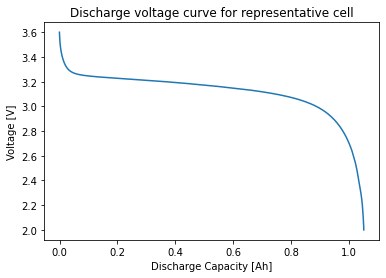

In [91]:
Qd = data_train[21,:,98]
Voltage = np.linspace(3.6, 2, 1000) # Batteries cycled from 3.6 V to 2 V

plt.plot(Qd, Voltage)
plt.xlabel("Discharge Capacity [Ah]")
plt.ylabel("Voltage [V]")
plt.title("Discharge voltage curve for representative cell")
plt.show()

### Generate features

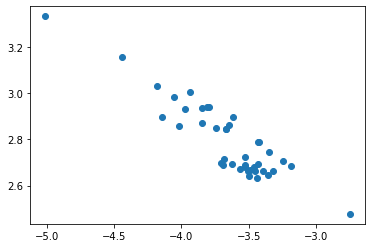

(41,)
(41,)
(41, 1000)
(41,)


In [189]:
from scipy.stats import skew, kurtosis

Qd100_10 = data_train[:, :, 98] - data_train[:, :, 8]

var_Qd = np.zeros(data_train.shape[0])
min_Qd = np.zeros(data_train.shape[0])
mean_Qd = np.zeros(data_train.shape[0])
skew_Qd = np.zeros(data_train.shape[0])
kurtosis_Qd = np.zeros(data_train.shape[0])

for i in range(data_train.shape[0]):
    var_Qd[i] = np.log10(abs(np.var(Qd100_10[i,:]))) # Var(Qd100-Qd10)
    min_Qd[i] = np.log10(abs(np.min(Qd100_10[i,:])))
    mean_Qd[i] = np.log10(abs(np.mean(Qd100_10[i,:])))
    skew_Qd[i] = np.log10(abs(skew(Qd100_10[i,:])))
    kurtosis_Qd[i] = np.log10(abs(kurtosis(Qd100_10[i,:])))
    
    

plt.scatter(var_Qd, y_train)
plt.show()
print(var_Qd.shape)
print(y_train.shape)
print(Qd100_10.shape)
print(skew_Qd.shape)

### Univariate models <a class="anchor" id="univariate"></a>

0.004751861075634056 0.013539711234700456 0.026106149319886276
[-0.00535771 -0.00704573 -0.00412649 -0.00462274 -0.00933957]


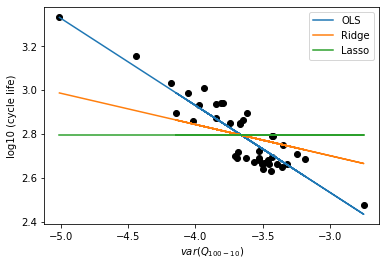

In [199]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import cross_val_score

x_train = var_Qd

linreg = LinearRegression()
lr = LinearRegression()
ridge = Ridge(alpha=10)
lasso = Lasso()
#enet = ElasticNetCV(l1_ratio=l1_ratios, cv=5, random_state=0)
#enet.fit(X_train_scaled, y_train)

linreg.fit(x_train.reshape(-1,1), y_train.reshape(-1,1))
ridge.fit(x_train.reshape(-1,1), y_train.reshape(-1,1))
lasso.fit(x_train.reshape(-1,1), y_train.reshape(-1,1))

ypred_ols = linreg.predict(x_train.reshape(-1,1))
ypred_ridge = ridge.predict(x_train.reshape(-1,1))
ypred_lasso = lasso.predict(x_train.reshape(-1,1))

mse_ols = mean_squared_error(y_train,ypred_ols)
mse_ridge = mean_squared_error(y_train,ypred_ridge)
mse_lasso = mean_squared_error(y_train,ypred_lasso)

print(mse_ols,mse_ridge,mse_lasso)
print(cross_val_score(lr, x_train.reshape(-1,1), y_train.reshape(-1,1), scoring='neg_mean_squared_error', cv=5))

plt.scatter(x_train, y_train, color="black")
plt.plot(x_train, ypred_ols, label="OLS")
plt.plot(x_train, ypred_ridge, label="Ridge")
plt.plot(x_train, ypred_lasso, label="Lasso")
plt.xlabel("$var(Q_{100-10})$")
plt.ylabel("log10 (cycle life)")
plt.legend()
plt.show()